In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Use this tag without writing plt.show()
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
# Ignore warning tips
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Import Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

all_data = pd.concat([train, test], ignore_index = True)

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [48]:
# The relationship between sex and survival
all_data.groupby(['Sex','Survived'])['Sex'].count()

Sex     Survived
female  0.0          81
        1.0         233
male    0.0         468
        1.0         109
Name: Sex, dtype: int64

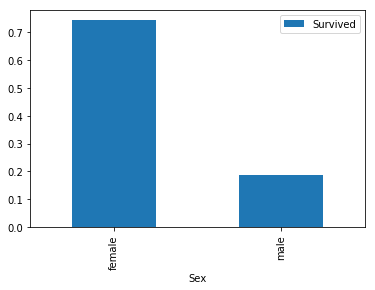

In [49]:
all_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

In [50]:
# Relationship between Pclass and survival
all_data.groupby(['Pclass','Survived'])['Pclass'].count()

Pclass  Survived
1       0.0          80
        1.0         136
2       0.0          97
        1.0          87
3       0.0         372
        1.0         119
Name: Pclass, dtype: int64

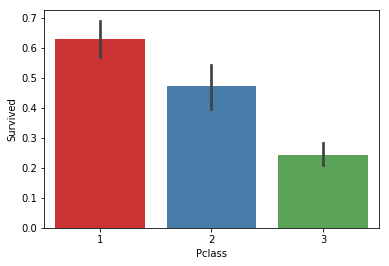

In [11]:
sns.barplot(x="Pclass", y="Survived", data=all_data, palette='Set1')

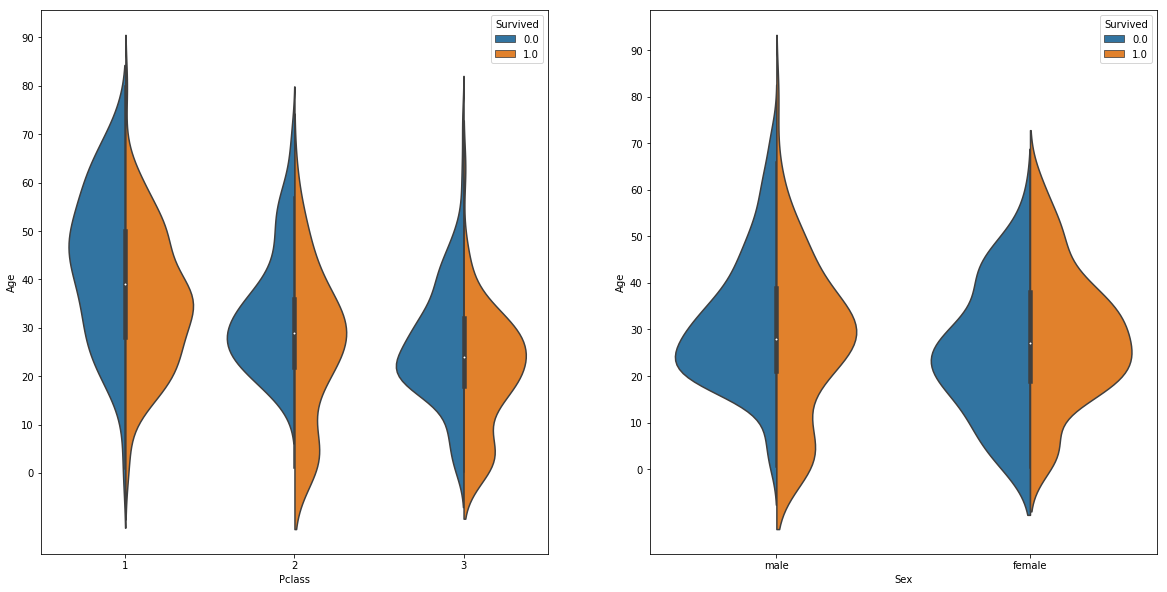

In [12]:
# Relationship between age distribution and survival in different classes of cabins and genders
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
sns.violinplot("Pclass", "Age", hue="Survived", data=all_data, split=True, ax=ax[0])

ax[0].set_yticks(range(0, 100, 10))

sns.violinplot("Sex", "Age", hue="Survived", data=all_data, split=True, ax=ax[1])

ax[1].set_yticks(range(0, 100, 10))

plt.show()

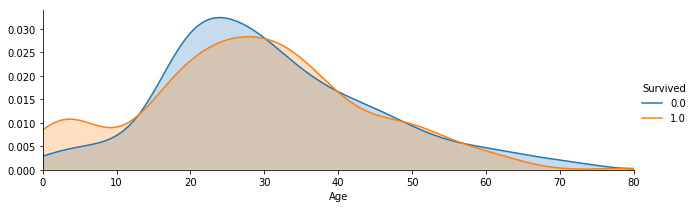

In [13]:
# Relationship between age and survival
facet = sns.FacetGrid(all_data, hue="Survived",aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

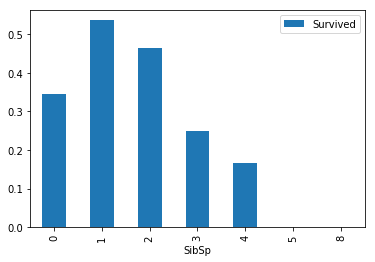

In [14]:
# A moderate number of spouses and siblings have a higher survival rate
all_data[['SibSp','Survived']].groupby(['SibSp']).mean().plot.bar()

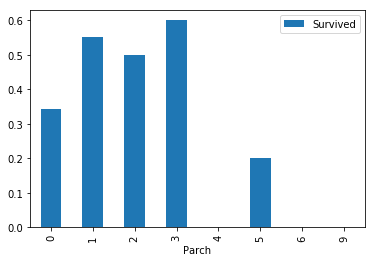

In [15]:
# Parents and children with a moderate number of passengers have a higher survival rate
all_data[['Parch','Survived']].groupby(['Parch']).mean().plot.bar()

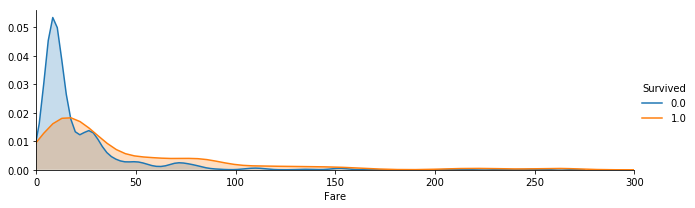

In [16]:
#The higher the expenditure ticket fee, the higher the survival rate
facet = sns.FacetGrid(all_data, hue="Survived",aspect=3)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 300))
facet.add_legend()

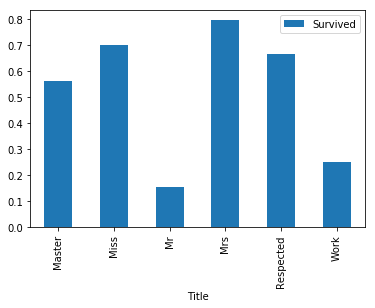

In [17]:
# Different survivors have different survival rates
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_new = {}
Title_new.update(dict.fromkeys(['Capt', 'Major', 'Dr','Rev'], 'Work'))
Title_new.update(dict.fromkeys([ 'Sir', 'the Countess','Don', 'Dona', 'Lady', 'Col'], 'Respected'))
Title_new.update(dict.fromkeys(['Ms','Mme','Mrs'], 'Mrs'))
Title_new.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
Title_new.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_new.update(dict.fromkeys(['Mr'], 'Mr'))

all_data['Title'] = all_data['Title'].map(Title_new)
all_data[['Title','Survived']].groupby(['Title']).mean().plot.bar()

In [18]:
# Different deck passengers have different survival rates

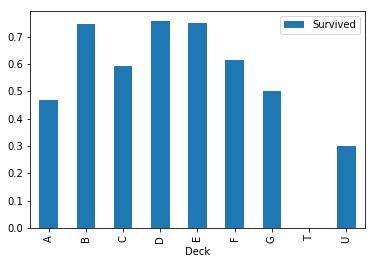

In [19]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
all_data[['Deck','Survived']].groupby(['Deck']).mean().plot.bar()

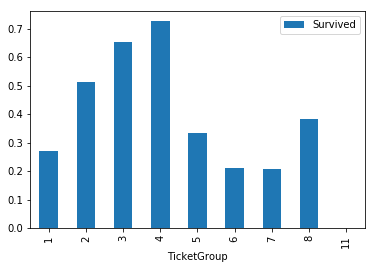

In [20]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
all_data[['TicketGroup','Survived']].groupby(['TicketGroup']).mean().plot.bar()

In [21]:
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)


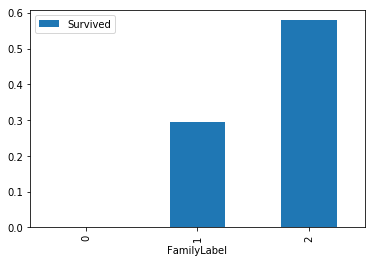

In [22]:
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
all_data[['FamilyLabel','Survived']].groupby(['FamilyLabel']).mean().plot.bar()

In [23]:
# Supplement age missing value
age_Df = all_data[['Age', 'Pclass','Sex','Title']]
age_Df=pd.get_dummies(age_Df)
Notnull_age = age_Df[age_Df.Age.notnull()].as_matrix()
Isnull_age = age_Df[age_Df.Age.isnull()].as_matrix()
Y = Notnull_age[:, 0]
X = Notnull_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, Y)
predictedAges = rfr.predict(Isnull_age[:, 1::])
all_data.loc[ (all_data.Age.isnull()), 'Age' ] = predictedAges 

In [24]:
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Deck,TicketGroup,FamilySize,FamilyLabel
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,B,2,1,1
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,B,2,1,1


In [25]:
# Supplement Embarked missing value
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [26]:
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Deck,TicketGroup,FamilySize,FamilyLabel
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,U,1,1,1


In [27]:
# Supplement Fare missing value
fare=all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)

In [28]:
# Analyze the relationship between surnames and gender and age
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
FemaleAndChild_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
MaleAndAdult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

In [29]:
FemaleAndChild=pd.DataFrame(FemaleAndChild_Group.groupby('Surname')['Survived'].mean().value_counts())
FemaleAndChild.columns=['GroupCount']
FemaleAndChild

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5,0,'AverageSurvived')

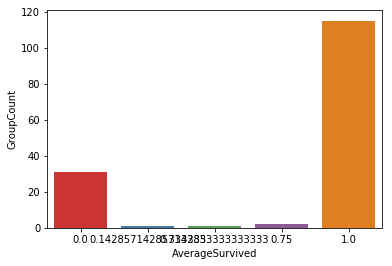

In [30]:
sns.barplot(x=FemaleAndChild.index, y=FemaleAndChild["GroupCount"], palette='Set1').set_xlabel('AverageSurvived')

In [31]:
MaleAndAdult=pd.DataFrame(MaleAndAdult_Group.groupby('Surname')['Survived'].mean().value_counts())
MaleAndAdult.columns=['GroupCount']
MaleAndAdult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


Text(0.5,0,'AverageSurvived')

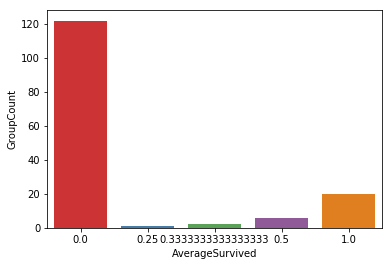

In [32]:
sns.barplot(x=MaleAndAdult.index, y=MaleAndAdult['GroupCount'], palette='Set1').set_xlabel('AverageSurvived')

In [33]:
# Penalty modification are made to Age, Title, and Sex of samples in the abnormal group in the test set.

FemaleAndChild_Group=FemaleAndChild_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(FemaleAndChild_Group[FemaleAndChild_Group.apply(lambda x:x==0)].index)
print(Dead_List)
MaleAndAdult_List=MaleAndAdult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(MaleAndAdult_List[MaleAndAdult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Turpin', 'Rosblom', 'Zabour', 'Danbom', 'Oreskovic', 'Vander Planke', 'Olsson', 'Lahtinen', 'Palsson', 'Johnston', 'Sage', 'Canavan', 'Lefebre', 'Ford', 'Bourke', 'Boulos', 'Robins', 'Barbara', 'Van Impe', 'Jussila', 'Strom', 'Lobb', 'Rice', 'Ilmakangas', 'Attalah', 'Cacic', 'Goodwin', 'Arnold-Franchi', 'Skoog', 'Panula', 'Caram'}
{'Dick', 'Greenfield', 'Goldenberg', 'Frolicher-Stehli', 'Beckwith', 'Taylor', 'Bishop', 'Jonsson', 'Kimball', 'Jussila', 'Cardeza', 'Harder', 'Frauenthal', 'McCoy', 'Chambers', 'Duff Gordon', 'Bradley', 'Beane', 'Nakid', 'Daly'}


In [34]:
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'


In [35]:
# Convert features to numeric variables
all_data=pd.concat([train, test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]

In [39]:
# Parameter optimization
pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 6, 'classify__n_estimators': 28} 0.8840699163271291


In [40]:
# Training model
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 28,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x000001E46F5F7400>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decreas...estimators=22, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

In [41]:
# Cross-validation
model_score = cross_validation.cross_val_score(pipeline, X, y, cv= 10)

print("CV Score : Mean - %.7g  " % (np.mean(model_score)))

CV Score : Mean - 0.8496096  


In [42]:
# prediction
predictions = pipeline.predict(test)